In [1]:
import praw
import psaw
import configparser
import googleapiclient.discovery
import googleapiclient.errors
from google.oauth2 import service_account
import re

service_key_file = "service_key.json"
config_path = 'autopolicjant.ini'
config = configparser.ConfigParser()          
config.read(config_path)
monitored_sub = 'Polska'

reddit = praw.Reddit(client_id=config['reddit']['client_id'],
                     client_secret=config['reddit']['client_secret'],
                     user_agent=config['reddit']['user_agent'],
                     password=config['reddit']['password'],
                     username=config['reddit']['username'])

pushift = psaw.PushshiftAPI(reddit)
credentials = service_account.Credentials.from_service_account_file(service_key_file)
youtube = googleapiclient.discovery.build("youtube", "v3", credentials=credentials)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tldextract
sns.set_theme(style="whitegrid")

In [3]:
def get_yt_details(yt_id):
    try:
        request = youtube.videos().list(part="snippet,statistics", id=yt_id)
        details = request.execute()
        details = details["items"][0]
        details = {
            'title': details["snippet"]["title"],
            'channel': (details["snippet"]["channelTitle"]).lower(),
            'description': details["snippet"]["description"],
        }
        return details
    except Exception as zonk:
        print(f"Error while getting {yt_id} Youtube video details: {zonk}")

def check_yt(submission):
    try:
        youtube_id = re.search('(?:v=|.be/|shorts/|embed/)(.{11})', submission.url)
        for match in youtube_id.groups():
            if match is not None:
                youtube_id = match
                channel = get_yt_details(youtube_id)['channel']
                return channel
        return 'youtube'
    except Exception as zonk:
        print(f"Error while doing Youtube check on submission {submission.id}: {zonk}")

In [4]:
groups = {
    'RAS': ['onet', 'businessinsider', 'fakt', 'komputerswiat', 'autoswiat', 'forbes', 'noizz', 'newsweek'],
    'natemat': ['natemat', 'innpoland', 'aszdziennik', 'mamadu', 'dadhero', 'natemat.pl.yt'],
    'WP': ['wp', 'money', 'dobreprogramy', 'polygamia', 'pudelek', 'vibez'],
    'Agora': ['gazeta', 'edziecko', 'avanti24', 'haps', 'wyborcza'],
    'TVN': ['tvn', 'tvn24', 'tvnwarszawa', 'kontakt24'],
    'Bonnier': ['pb', 'bankier', 'pit', 'prnews', 'mambiznes', 'pulsmedycyny', 'pulsfarmacji'],
    'Bauer': ['rmf', 'rmf24'],
    'Polsat': ['polsatnews', 'interia', 'esporter', 'styl', 'bravo', 'pomponik', 'swiatseriali'],
    'ZPR': ['se', 'superbiz', 'eska', 'murator', 'poradnikzdrowie'],
    'PTWP': ['dlahandlu', 'farmer', 'wnp', 'parlamentarny', 'portalsamorzadowy', 'portalspozywczy', 'rynekzdrowia', 'pulshr', 'propertynews'],
    'Spider': ['spidersweb', 'bezprawnik', 'autoblog', 'bizblog'],
    'PMPG': ['wprost', 'dorzeczy'],
    'Infor': ['infor', 'gazetaprawna', 'dgp', 'dziennik', 'forsal']
}


In [5]:
post_table = pd.DataFrame(columns=('id','time','title','url','domain', 'group', 'score', 'ratio', 'author'))
post_table['score'] = pd.to_numeric(post_table['score'])
post_table['ratio'] = pd.to_numeric(post_table['ratio'])
ignored_domains = ['redd.it', 'reddit.com', 'imgur.com', 'twitter.com', 'facebook.com', 'gov.pl', 'streamable.com', 'wykop.pl', '/r/']

for submission in reddit.subreddit(monitored_sub).new(limit=1000):
    if not any(x in submission.url for x in ignored_domains):
        domain = tldextract.extract(submission.url).domain
        if domain == 'blogspot' or domain == 'substack':
            domain = tldextract.extract(submission.url).subdomain + ' (blog)'      
        elif domain in ['youtube', 'youtu']:
            domain = check_yt(submission) + ' (YT)'
        temp_group = None
        for group in groups:
            if domain in groups[group]:
                temp_group = group
        if temp_group == None:
            temp_group = 'Unaffiliated'
        try:
            post_table = post_table.append({
                'id': submission.id, 
                'time': submission.created_utc, 
                'title': submission.title,
                'url': submission.url,
                'domain': domain,
                'group': temp_group,
                'score': submission.score,
                'ratio': submission.upvote_ratio,
                'author': submission.author.name}, 
                ignore_index=True)
        except Exception as zonk:
            post_table = post_table.append({
                'id': submission.id, 
                'time': submission.created_utc, 
                'title': submission.title,
                'url': submission.url,
                'domain': domain,
                'group': temp_group,
                'score': submission.score,
                'ratio': submission.upvote_ratio,
                'author': '[deleted]'}, 
                ignore_index=True)


<function matplotlib.pyplot.show(close=None, block=None)>

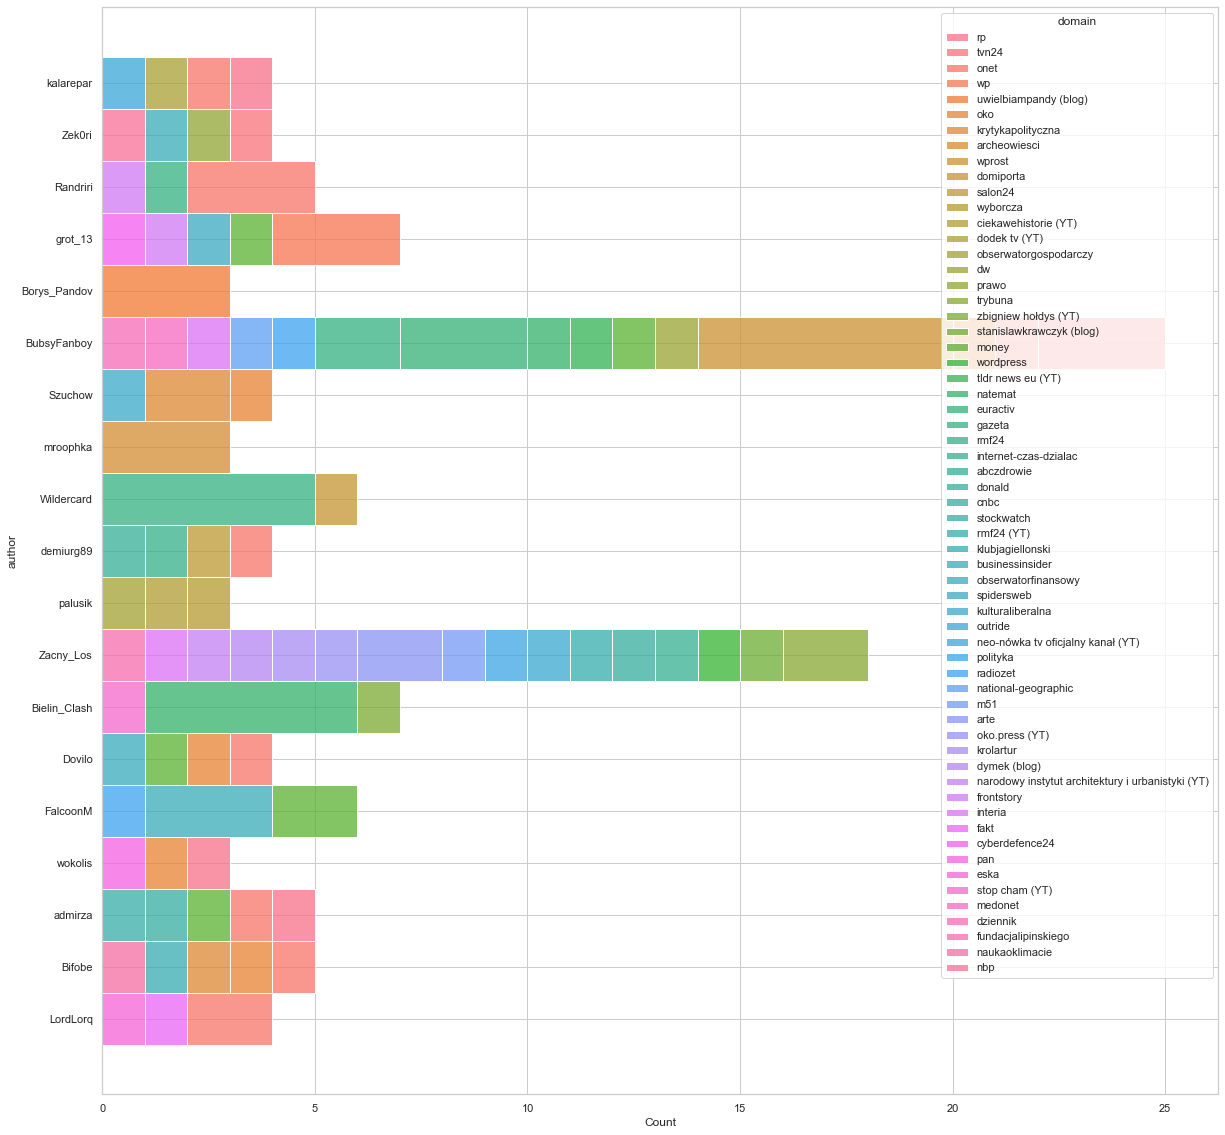

In [6]:
top_users = post_table[post_table['author'].map(post_table['author'].value_counts()) > 2]
plt.figure(figsize=(20, 20))
sns.histplot(
    top_users,
    y="author", hue="domain",
    multiple="stack",
)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

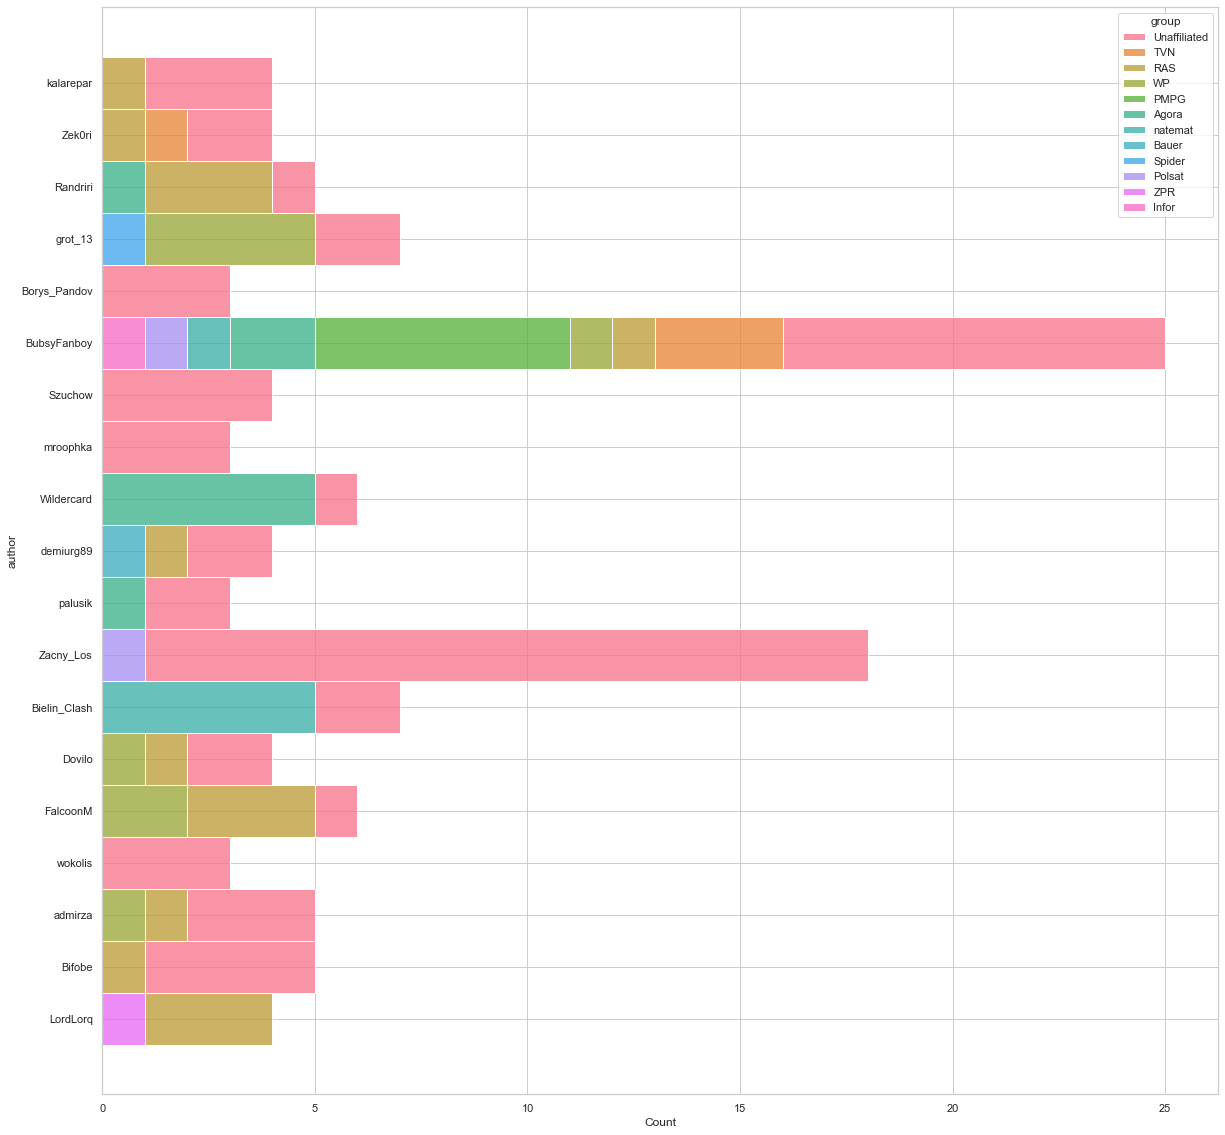

In [7]:
top_users = post_table[post_table['author'].map(post_table['author'].value_counts()) > 2]
plt.figure(figsize=(20, 20))
sns.histplot(
    top_users,
    y="author", hue="group",
    multiple="stack",
)
plt.show

/opt/homebrew/lib/python3.9/site-packages/seaborn/distributions.py:154: UserWarning: The handle <matplotlib.patches.Patch object at 0x169aaac70> has a label of '_R_Daneel_Olivaw' which cannot be automatically added to the legend.
  ax_obj.legend(handles, labels, title=self.variables["hue"], **legend_kws)


<function matplotlib.pyplot.show(close=None, block=None)>

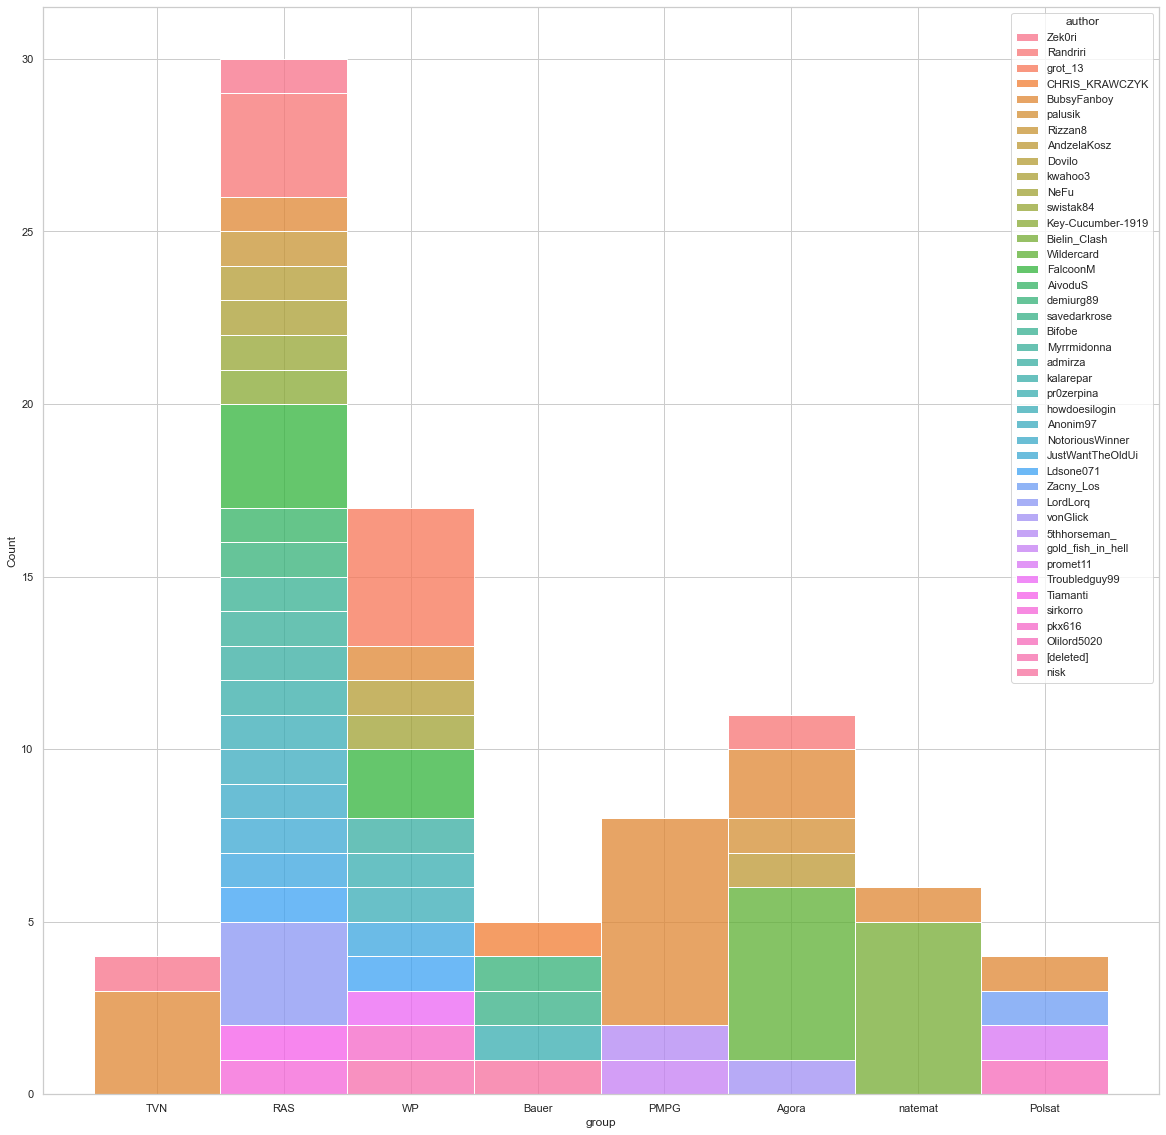

In [8]:
top_groups = post_table[post_table['group'].map(post_table['group'].value_counts()) > 2]
top_groups = top_groups[top_groups['group'] != 'Unaffiliated']
plt.figure(figsize=(20, 20))
sns.histplot(
    top_groups,
    x="group", hue="author",
    multiple="stack",
)
plt.show

In [9]:
reddit.submission('wb3p1u').subreddit.display_name

'Polska'